In [1]:
from IPython.core.magic import register_cell_magic
import os
from pathlib import Path

## define custom magic to save most useful classes and use them in inference notebook 
## instead of copying the code every time you have changes in the classes
@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)
    
Path('/kaggle/working/scripts').mkdir(exist_ok=True)
models_dir = Path('/kaggle/working/models')
models_dir.mkdir(exist_ok=True)

In [2]:
%%write_and_run scripts/imports.py

import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler, Sampler
from torch.nn.functional import mse_loss
from transformers import AutoModel,AutoTokenizer,get_cosine_schedule_with_warmup, AutoConfig, AdamW
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
# print(plt.style.available)
from time import time
from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
g_ = Fore.GREEN
y_ = Fore.YELLOW
w_ = Fore.WHITE
bb_ = Back.BLACK
sr_ = Style.RESET_ALL

In [3]:
%%write_and_run scripts/config.py

class Config:
    model_name = '../input/clrp-roberta-large/clrp_roberta_large'
    output_hidden_states = True
    epochs = 5
#     evaluate_interval = 40
    batch_size = 8
    device = 'cuda'
    seed = 42
    max_len = 256
    lr = 1e-5
    wd = 0.01
#     eval_schedule = [(float('inf'), 40), (0.5, 30), (0.49, 20), (0.48, 10), (0.47, 3), (0, 0)]
    eval_schedule = [(float('inf'), 40), (0.47, 20), (0.46, 10), (0, 0)]

    gradient_accumulation = 2

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=Config.seed)

In [5]:
# train_df = pd.read_csv('../input/k/chamecall/train-val-split/train.csv')
# val_df = pd.read_csv('../input/k/chamecall/train-val-split/val.csv')

kfold_df = pd.read_csv('../input/k/chamecall/train-val-split/kfold.csv')

In [6]:
%%write_and_run scripts/dataset.py

from torch.utils.data import Dataset
import torch

def convert_examples_to_features(text, tokenizer, max_len):

    tok = tokenizer.encode_plus(
        text, 
        max_length=max_len, 
        truncation=True,
        padding='max_length',
    )
    return tok


class CLRPDataset(Dataset):
    def __init__(self, data, tokenizer, max_len, is_test=False):
        self.data = data
        self.excerpts = self.data.excerpt.tolist()
        if not is_test:
            self.targets = self.data.target.tolist()
            
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        if not self.is_test:
            excerpt = self.excerpts[item]
            label = self.targets[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
                'label':torch.tensor(label, dtype=torch.float),
            }
        else:
            excerpt = self.excerpts[item]
            features = convert_examples_to_features(
                excerpt, self.tokenizer, self.max_len
            )
            return {
                'input_ids':torch.tensor(features['input_ids'], dtype=torch.long),
                'attention_mask':torch.tensor(features['attention_mask'], dtype=torch.long),
            }

In [7]:
%%write_and_run scripts/model.py

import torch
import torch.nn as nn

class AttentionHead(nn.Module):
    def __init__(self, h_size, hidden_dim=512):
        super().__init__()
        self.W = nn.Linear(h_size, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        
    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

class CLRPModel(nn.Module):
    def __init__(self,transformer,config):
        super(CLRPModel,self).__init__()
        self.h_size = config.hidden_size
        self.transformer = transformer
        self.head = AttentionHead(self.h_size*4)
        self.linear = nn.Linear(self.h_size*2, 1)
        self.linear_out = nn.Linear(self.h_size*8, 1)

              
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer(input_ids, attention_mask)
       
        all_hidden_states = torch.stack(transformer_out.hidden_states)
        cat_over_last_layers = torch.cat(
            (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]),-1
        )
        
        cls_pooling = cat_over_last_layers[:, 0]   
        head_logits = self.head(cat_over_last_layers)
        y_hat = self.linear_out(torch.cat([head_logits, cls_pooling], -1))
        
        return y_hat

In [8]:
def create_optimizer(model):
    named_parameters = list(model.named_parameters())    
    
    roberta_parameters = named_parameters[:389]    
    attention_parameters = named_parameters[391:395]
    regressor_parameters = named_parameters[395:]
        
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]

    parameters = []
    parameters.append({"params": attention_group})
    parameters.append({"params": regressor_group})
    
    # increase lr every second layer
    increase_lr_every_k_layer = 1
    lrs = np.linspace(1, 5, 24 // increase_lr_every_k_layer)
    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if "bias" in name else 0.01
        splitted_name = name.split('.')
        lr = Config.lr
        if len(splitted_name) >= 4 and str.isdigit(splitted_name[3]):
            layer_num = int(splitted_name[3])
            lr = lrs[layer_num // increase_lr_every_k_layer] * Config.lr 

        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})

    return optim.AdamW(parameters)

In [9]:
   
    
class DynamicPadCollate:
    def __call__(self,batch):
                
        out = {'input_ids' :[],
               'attention_mask':[],
                'label':[]
        }
        
        for i in batch:
            for k,v in i.items():
                out[k].append(v)
                
        max_pad =0

        for p in out['input_ids']:
            if max_pad < len(p):
                max_pad = len(p)
                    

        for i in range(len(batch)):
            
            input_id = out['input_ids'][i]
            att_mask = out['attention_mask'][i]
            text_len = len(input_id)
            
            out['input_ids'][i] = (out['input_ids'][i].tolist() + [1] * (max_pad - text_len))[:max_pad]
            out['attention_mask'][i] = (out['attention_mask'][i].tolist() + [0] * (max_pad - text_len))[:max_pad]
        
        out['input_ids'] = torch.tensor(out['input_ids'],dtype=torch.long)
        out['attention_mask'] = torch.tensor(out['attention_mask'],dtype=torch.long)
        out['label'] = torch.tensor(out['label'],dtype=torch.float)
        
        return out


class AvgCounter:
    def __init__(self):
        self.reset()
        
    def update(self, loss, n_samples):
        self.loss += loss * n_samples
        self.n_samples += n_samples
        
    def avg(self):
        return self.loss / self.n_samples
    
    def reset(self):
        self.loss = 0
        self.n_samples = 0

class EvaluationScheduler:
    def __init__(self, evaluation_schedule, penalize_factor=1, max_penalty=8):
        self.evaluation_schedule = evaluation_schedule
        self.evaluation_interval = self.evaluation_schedule[0][1]
        self.last_evaluation_step = 0
        self.prev_loss = float('inf')
        self.penalize_factor = penalize_factor
        self.penalty = 0
        self.prev_interval = -1
        self.max_penalty = max_penalty

    def step(self, step):
        # should we to make evaluation right now
        if step >= self.last_evaluation_step + self.evaluation_interval:
            self.last_evaluation_step = step
            return True
        else:
            return False
        
            
    def update_evaluation_interval(self, last_loss):
        # set up evaluation_interval depending on loss value
        cur_interval = -1
        for i, (loss, interval) in enumerate(self.evaluation_schedule[:-1]):
            if self.evaluation_schedule[i+1][0] < last_loss < loss:
                self.evaluation_interval = interval
                cur_interval = i
                break
#         if last_loss > self.prev_loss and self.prev_interval == cur_interval:
#             self.penalty += self.penalize_factor
#             self.penalty = min(self.penalty, self.max_penalty)
#             self.evaluation_interval += self.penalty
#         else:
#             self.penalty = 0
            
        self.prev_loss = last_loss
        self.prev_interval = cur_interval
        
          
        
def make_dataloader(data, tokenizer, is_train=True):
    dataset = CLRPDataset(data, tokenizer=tokenizer, max_len=Config.max_len)
    if is_train:
        sampler = RandomSampler(dataset)
    else:
        sampler = SequentialSampler(dataset)

    batch_dataloader = DataLoader(dataset, sampler=sampler, batch_size=Config.batch_size, pin_memory=True, collate_fn=DynamicPadCollate())
    return batch_dataloader
                   
            
class Trainer:
    def __init__(self, train_dl, val_dl, model, optimizer, scheduler, scaler, criterion, model_num):
        self.train_dl = train_dl
        self.val_dl = val_dl
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = Config.device
        self.batches_per_epoch = len(self.train_dl)
        self.total_batch_steps = self.batches_per_epoch * Config.epochs
        self.criterion = criterion
        self.model_num = model_num
        
        self.scaler = scaler
                
    def run(self):
        record_info = {
            'train_loss': [],
            'val_loss': [],
        }
        
        best_val_loss = float('inf')
        evaluation_scheduler = EvaluationScheduler(Config.eval_schedule)
        train_loss_counter = AvgCounter()
        step = 0
        
        for epoch in range(Config.epochs):
            
            print(f'{r_}Epoch: {epoch+1}/{Config.epochs}{sr_}')
            start_epoch_time = time()
            
            for batch_num, batch in enumerate(self.train_dl):
                train_loss = self.train(batch, step)
#                 print(f'{epoch+1}#[{step+1}/{len(self.train_dl)}]: train loss - {train_loss.item()}')

                train_loss_counter.update(train_loss, len(batch))
                record_info['train_loss'].append((step, train_loss.item()))

                if evaluation_scheduler.step(step):
                    val_loss = self.evaluate()
                    
                    record_info['val_loss'].append((step, val_loss.item()))        
                    print(f'\t\t{epoch+1}#[{batch_num+1}/{self.batches_per_epoch}]: train loss - {train_loss_counter.avg()} | val loss - {val_loss}',)
                    train_loss_counter.reset()

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss.item()
                        print(f"\t\t{g_}Val loss decreased from {best_val_loss} to {val_loss}{sr_}")
                        torch.save(self.model.state_dict(), models_dir / f'best_model_{self.model_num}.pth')
                        
                    evaluation_scheduler.update_evaluation_interval(val_loss.item())
                        
            
                step += 1
            end_epoch_time = time()
            print(f'{bb_}{y_}The epoch took {end_epoch_time - start_epoch_time} sec..{sr_}')

        return record_info, best_val_loss
            

    def train(self, batch, batch_step):
        self.model.train()
        sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device)
        with autocast():
            preds = self.model(sent_id, mask)
            train_loss = self.criterion(preds, labels.unsqueeze(1))
        
        self.scaler.scale(train_loss).backward()
#         train_loss.backward()
        
        if (batch_step + 1) % Config.gradient_accumulation or batch_step+1 == self.total_batch_steps:
            self.scaler.step(self.optimizer)
            self.scaler.update()
#             self.optimizer.step()
            self.model.zero_grad() 
        self.scheduler.step()
        return torch.sqrt(train_loss)

    def evaluate(self):
        self.model.eval()
        val_loss_counter = AvgCounter()

        for step,batch in enumerate(self.val_dl):
            sent_id, mask, labels = batch['input_ids'].to(self.device), batch['attention_mask'].to(self.device), batch['label'].to(self.device)
            with torch.no_grad():
                with autocast():
                    preds = self.model(sent_id, mask)
                    loss = self.criterion(preds,labels.unsqueeze(1))
                val_loss_counter.update(torch.sqrt(loss), len(labels))
        return val_loss_counter.avg()
    
    
def mse_loss(y_true,y_pred):
    return nn.functional.mse_loss(y_true,y_pred)

  Model#1  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		1#[41/284]: train loss - 1.0974111557006836 | val loss - 0.7515143156051636
		Val loss decreased from 0.7515143156051636 to 0.7515143156051636
		1#[81/284]: train loss - 0.7020877003669739 | val loss - 0.6307758688926697
		Val loss decreased from 0.6307758688926697 to 0.6307758688926697
		1#[121/284]: train loss - 0.6585418581962585 | val loss - 0.5561102628707886
		Val loss decreased from 0.5561102628707886 to 0.5561102628707886
		1#[161/284]: train loss - 0.6494287848472595 | val loss - 0.5631223917007446
		1#[201/284]: train loss - 0.6490339636802673 | val loss - 0.4883362352848053
		Val loss decreased from 0.4883362352848053 to 0.4883362352848053
		1#[241/284]: train loss - 0.5468639731407166 | val loss - 0.6550028324127197
		1#[281/284]: train loss - 0.5617213249206543 | val loss - 0.5037437677383423
The epoch took 357.1918671131134 sec..
Epoch: 2/5
		2#[37/284]: train loss - 0.4709400236606598 | val loss - 0.7635009288787842
		2#[77/284]: train loss - 0.5688661336898

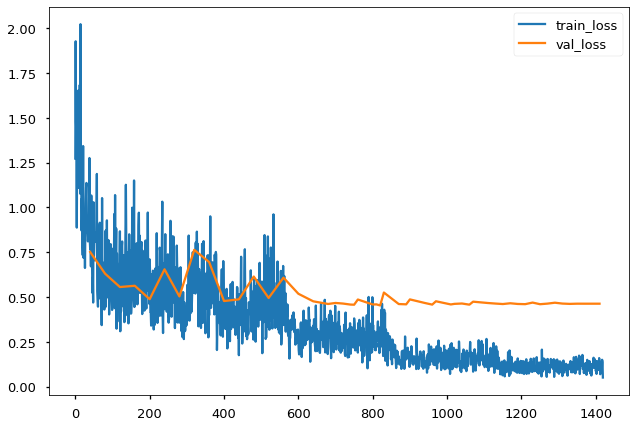

  Model#2  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		1#[41/284]: train loss - 1.2451592683792114 | val loss - 0.7743475437164307
		Val loss decreased from 0.7743475437164307 to 0.7743475437164307
		1#[81/284]: train loss - 0.7713847756385803 | val loss - 0.7699521780014038
		Val loss decreased from 0.7699521780014038 to 0.7699521780014038
		1#[121/284]: train loss - 0.6831604242324829 | val loss - 0.6939632296562195
		Val loss decreased from 0.6939632296562195 to 0.6939632296562195
		1#[161/284]: train loss - 0.6481692790985107 | val loss - 0.6225797533988953
		Val loss decreased from 0.6225797533988953 to 0.6225797533988953
		1#[201/284]: train loss - 0.6489338874816895 | val loss - 0.5571286678314209
		Val loss decreased from 0.5571286678314209 to 0.5571286678314209
		1#[241/284]: train loss - 0.6327399611473083 | val loss - 0.5370604991912842
		Val loss decreased from 0.5370604991912842 to 0.5370604991912842
		1#[281/284]: train loss - 0.5498784780502319 | val loss - 0.5357762575149536
		Val loss decreased from 0.53577625

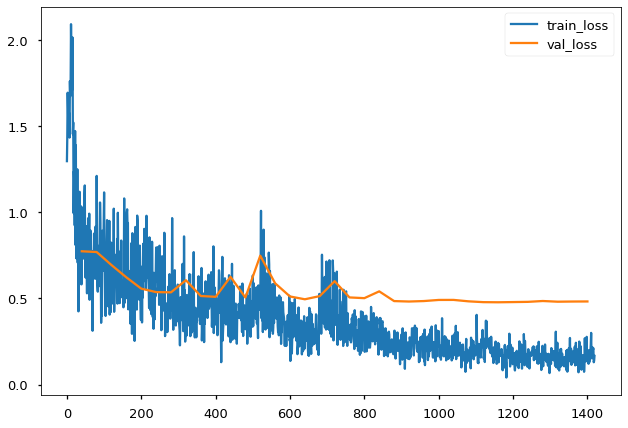

  Model#3  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		1#[41/284]: train loss - 1.0435457229614258 | val loss - 0.74295574426651
		Val loss decreased from 0.74295574426651 to 0.74295574426651
		1#[81/284]: train loss - 0.742635190486908 | val loss - 0.8279643058776855
		1#[121/284]: train loss - 0.6364368796348572 | val loss - 0.5887746214866638
		Val loss decreased from 0.5887746214866638 to 0.5887746214866638
		1#[161/284]: train loss - 0.5887908339500427 | val loss - 0.6084546446800232
		1#[201/284]: train loss - 0.6001662611961365 | val loss - 0.6814209818840027
		1#[241/284]: train loss - 0.6209856271743774 | val loss - 0.724117636680603
		1#[281/284]: train loss - 0.5977075099945068 | val loss - 0.5330506563186646
		Val loss decreased from 0.5330506563186646 to 0.5330506563186646
The epoch took 349.9413299560547 sec..
Epoch: 2/5
		2#[37/284]: train loss - 0.5128783583641052 | val loss - 0.6316210627555847
		2#[77/284]: train loss - 0.5216596126556396 | val loss - 0.5610641837120056
		2#[117/284]: train loss - 0.540116608

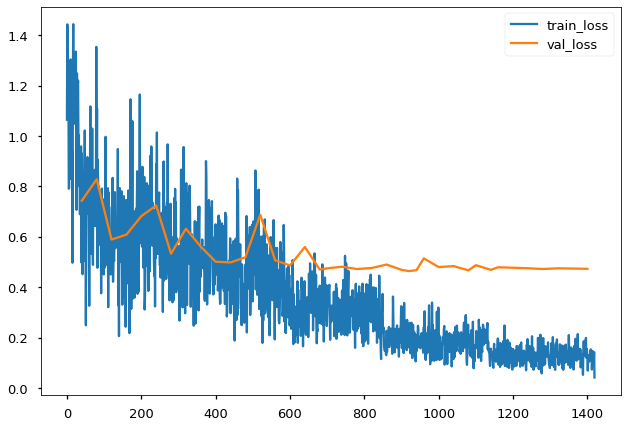

  Model#4  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		1#[41/284]: train loss - 0.8934881091117859 | val loss - 0.7047051191329956
		Val loss decreased from 0.7047051191329956 to 0.7047051191329956
		1#[81/284]: train loss - 0.6902078986167908 | val loss - 0.5970615148544312
		Val loss decreased from 0.5970615148544312 to 0.5970615148544312
		1#[121/284]: train loss - 0.5717869997024536 | val loss - 0.5680177211761475
		Val loss decreased from 0.5680177211761475 to 0.5680177211761475
		1#[161/284]: train loss - 0.6794984936714172 | val loss - 0.5997903347015381
		1#[201/284]: train loss - 0.5573313236236572 | val loss - 0.5861473083496094
		1#[241/284]: train loss - 0.7244762778282166 | val loss - 0.5749425292015076
		1#[281/284]: train loss - 0.6540305614471436 | val loss - 0.5188648104667664
		Val loss decreased from 0.5188648104667664 to 0.5188648104667664
The epoch took 352.229186296463 sec..
Epoch: 2/5
		2#[37/284]: train loss - 0.4904029667377472 | val loss - 0.5522698163986206
		2#[77/284]: train loss - 0.44323948025703

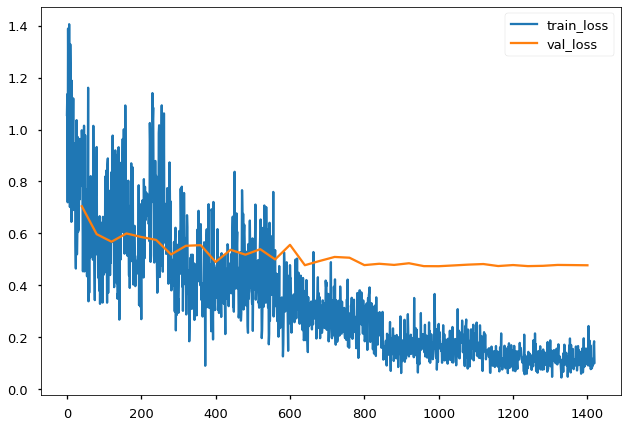

  Model#5  


Some weights of RobertaModel were not initialized from the model checkpoint at ../input/clrp-roberta-large/clrp_roberta_large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 1/5
		1#[41/284]: train loss - 1.3068050146102905 | val loss - 0.804050862789154
		Val loss decreased from 0.804050862789154 to 0.804050862789154
		1#[81/284]: train loss - 0.6940696239471436 | val loss - 0.7677001953125
		Val loss decreased from 0.7677001953125 to 0.7677001953125
		1#[121/284]: train loss - 0.6454249620437622 | val loss - 0.8163485527038574
		1#[161/284]: train loss - 0.7075326442718506 | val loss - 0.7953728437423706
		1#[201/284]: train loss - 0.6476233005523682 | val loss - 0.5780722498893738
		Val loss decreased from 0.5780722498893738 to 0.5780722498893738
		1#[241/284]: train loss - 0.7013580799102783 | val loss - 0.6356066465377808
		1#[281/284]: train loss - 0.6095002889633179 | val loss - 0.5984733700752258
The epoch took 348.22052454948425 sec..
Epoch: 2/5
		2#[37/284]: train loss - 0.5584471225738525 | val loss - 0.5798182487487793
		2#[77/284]: train loss - 0.47827911376953125 | val loss - 0.5368356108665466
		Val loss decreased from 0.5368356108665

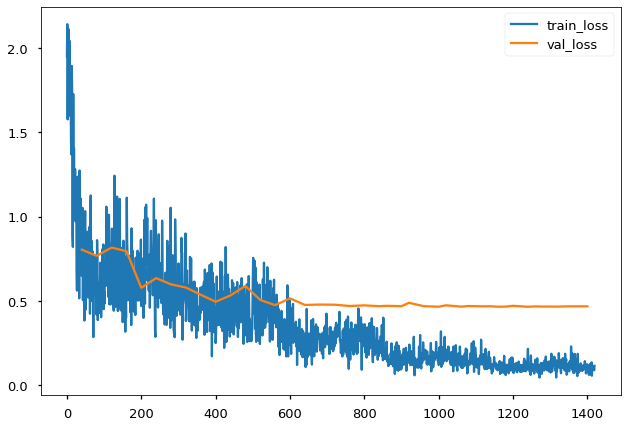

Best val losses: [0.45328888297080994, 0.4779704511165619, 0.4638442397117615, 0.47364991903305054, 0.4657805263996124]
Avg val loss: 0.46690680384635924


In [10]:
best_scores = []

for model_num in range(5): 
    print(f'{bb_}{w_}  Model#{model_num+1}  {sr_}')
    
    seed_everything(seed=(Config.seed + (model_num * 10))** 2)
    
    tokenizer = AutoTokenizer.from_pretrained(Config.model_name)
    config = AutoConfig.from_pretrained(Config.model_name)
    config.update({
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7,
            "output_hidden_states": True
            }) 

    train_dl = make_dataloader(kfold_df[kfold_df.fold!=model_num], tokenizer)
    val_dl = make_dataloader(kfold_df[kfold_df.fold==model_num], tokenizer, is_train=False)

    transformer = AutoModel.from_pretrained(Config.model_name, config=config)  

    model = CLRPModel(transformer, config)
    
    model = model.to(Config.device)
    optimizer = create_optimizer(model)
    scaler = GradScaler()
#     optimizer = optim.AdamW(model.parameters(), lr=Config.lr)
    scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_training_steps=Config.epochs * len(train_dl),
            num_warmup_steps=len(train_dl) * Config.epochs * 0.11)  

    criterion = mse_loss

    trainer = Trainer(train_dl, val_dl, model, optimizer, scheduler, scaler, criterion, model_num)
    record_info, best_val_loss = trainer.run()
    best_scores.append(best_val_loss)    
    
    steps, train_losses = list(zip(*record_info['train_loss']))
    plt.plot(steps, train_losses, label='train_loss')
    steps, val_losses = list(zip(*record_info['val_loss']))
    plt.plot(steps, val_losses, label='val_loss')
    plt.legend()
    plt.show()
    
print('Best val losses:', best_scores)
print('Avg val loss:', np.array(best_scores).mean())
!date '+%A %W %Y %X' > execution_time